In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal
from load_landlab_nc_files import load_landlab_nc_files
import xarray as xr
import pickle

In [2]:
path_to_netcdf_az = '/run/user/1000/gvfs/smb-share:server=134.2.5.43,share=esd01/data/mschmid/model_runs/runningSimus/paper_2/trace_simulations/Ff_02/realistic_base_elevation/coupled_vegi_precip/individual_plant_types/higher_K/az/'
path_to_netcdf_sg = '/run/user/1000/gvfs/smb-share:server=134.2.5.43,share=esd01/data/mschmid/model_runs/runningSimus/paper_2/trace_simulations/Ff_02/realistic_base_elevation/coupled_vegi_precip/individual_plant_types/higher_K/sg/'
path_to_netcdf_lc = '/run/user/1000/gvfs/smb-share:server=134.2.5.43,share=esd01/data/mschmid/model_runs/runningSimus/paper_2/trace_simulations/Ff_02/realistic_base_elevation/coupled_vegi_precip/individual_plant_types/higher_K/lc/'
path_to_netcdf_na = '/run/user/1000/gvfs/smb-share:server=134.2.5.43,share=esd01/data/mschmid/model_runs/runningSimus/paper_2/trace_simulations/Ff_02/realistic_base_elevation/coupled_vegi_precip/individual_plant_types/higher_K/na/'

sim_list = [path_to_netcdf_az, path_to_netcdf_sg, path_to_netcdf_lc, path_to_netcdf_na]
name_list = ['az', 'sg', 'lc', 'na']

#dataDict = load_landlab_nc_files(sim_list, name_list, use_means = False, do_pickle = True, pickle_name = 'indi_pheno_types_data.p')
dataDict = load_landlab_nc_files(sim_list, name_list, use_means = False, do_pickle = False, pickle_name = 'indi_pheno_types_data.p')

Data loading of az Simulation
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
Data loading of sg Simulation
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
Data loading of lc Simulation
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
Data loading of na Simulation
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
100 files done
do_pickle is false. I am not saving a bi

In [16]:
area = 'az'

length_of_dataseries = np.shape(dataDict[area]['erosion__rate'])[0]

#hilltops
top_erosion_rates    = np.zeros(length_of_dataseries)
top_tree_cover       = np.zeros(length_of_dataseries)
top_shrub_cover      = np.zeros(length_of_dataseries)
top_grass_cover      = np.zeros(length_of_dataseries)
top_vegi_cover       = np.zeros(length_of_dataseries)
top_rainvalue        = np.zeros(length_of_dataseries)
top_soil_depth       = np.zeros(length_of_dataseries)

#slopes
#_slope_erosion_rates  = np.array([])
#_slope_tree_cover     = np.array([]) 
#_slope_shrub_cover    = np.array([])
#_slope_grass_cover    = np.array([])
#_slope_vegi_cover     = np.array([])
#_slope_rainvalue      = np.array([])
#_slope_soil_depth     = np.array([])

slope_erosion_rates  = np.zeros(length_of_dataseries)
slope_tree_cover     = np.zeros(length_of_dataseries)
slope_shrub_cover    = np.zeros(length_of_dataseries)
slope_grass_cover    = np.zeros(length_of_dataseries)
slope_vegi_cover     = np.zeros(length_of_dataseries)
slope_rainvalue      = np.zeros(length_of_dataseries)
slope_soil_depth     = np.zeros(length_of_dataseries)


#valleys
valley_erosion_rates  = np.zeros(length_of_dataseries)
valley_tree_cover     = np.zeros(length_of_dataseries)
valley_shrub_cover    = np.zeros(length_of_dataseries)
valley_grass_cover    = np.zeros(length_of_dataseries)
valley_vegi_cover     = np.zeros(length_of_dataseries)
valley_rainvalue      = np.zeros(length_of_dataseries)
valley_soil_depth     = np.zeros(length_of_dataseries)


#flats
flat_erosion_rates   = np.zeros(length_of_dataseries)
flat_tree_cover      = np.zeros(length_of_dataseries)
flat_shrub_cover     = np.zeros(length_of_dataseries)
flat_grass_cover     = np.zeros(length_of_dataseries)
flat_vegi_cover      = np.zeros(length_of_dataseries)
flat_rainvalue       = np.zeros(length_of_dataseries)
flat_soil_depth      = np.zeros(length_of_dataseries)



for timeslice in range(length_of_dataseries):
    
    #create temporary arrays for saving in a single timeslice
    _s_erosion_rate_for_lf_indices = []
    _s_soil_depth_for_lf_indices   = []
    _s_grass_cover_for_lf_indices = []
    _s_tree_cover_for_lf_indices  = []
    _s_shrub_cover_for_lf_indices = []
    _s_vegi_cover_for_lf_indices  = []
    _s_rainvalue_for_lf_indices   = []
    
    _h_erosion_rate_for_lf_indices = []
    _h_soil_depth_for_lf_indices   = []
    _h_grass_cover_for_lf_indices = []
    _h_tree_cover_for_lf_indices  = []
    _h_shrub_cover_for_lf_indices = []
    _h_vegi_cover_for_lf_indices  = []
    _h_rainvalue_for_lf_indices   = []
    
    _v_erosion_rate_for_lf_indices = []
    _v_soil_depth_for_lf_indices   = []
    _v_grass_cover_for_lf_indices = []
    _v_tree_cover_for_lf_indices  = []
    _v_shrub_cover_for_lf_indices = []
    _v_vegi_cover_for_lf_indices  = []
    _v_rainvalue_for_lf_indices   = []
    
    _f_erosion_rate_for_lf_indices = []
    _f_soil_depth_for_lf_indices   = []
    _f_grass_cover_for_lf_indices = []
    _f_tree_cover_for_lf_indices  = []
    _f_shrub_cover_for_lf_indices = []
    _f_vegi_cover_for_lf_indices  = []
    _f_rainvalue_for_lf_indices   = []
    
    
    #extract landforms, erosionrates and unique landforms per timeslice.
    #I flatten the matrices into 1D-arrays because the indexing gets easier
    _lf_array = dataDict[area]['landform__ID'][timeslice].flatten()
    _erosion_array = dataDict[area]['erosion__rate'][timeslice].flatten()
    
    #soil depth
    _soil_array = dataDict[area]['soil__depth'][timeslice].flatten()
    
    #vegetation arrays
    _tree_array  = dataDict[area]['tree_fpc'][timeslice].flatten()
    _shrub_array = dataDict[area]['shrub_fpc'][timeslice].flatten()
    _grass_array = dataDict[area]['grass_fpc'][timeslice].flatten()
    _vegi_array  = dataDict[area]['vegetation__density'][timeslice].flatten()
    
    #unique_lfs
    _unique_lfs = np.unique(dataDict[area]['landform__ID'][timeslice].flatten())
    
    #rain
    _rain_array = dataDict[area]['precipitation'][timeslice].flatten()
  
    for lfs in _unique_lfs:
        lfs = str(int(lfs))
        if lfs[-2] == '3':
            #extract indices
            _slope_erosion_indices_temp = np.where(_lf_array == int(lfs))
            #extract erosion rates per indices
            _erosion_rate_for_lf_indices = [_erosion_array[i] for i in _slope_erosion_indices_temp]
           
            #extract soil_depth per indices
            _soil_depth_for_lf_indices  = [_soil_array[i]  for i in _slope_erosion_indices_temp]
            #extract vegi-values per indicesi
            _grass_cover_for_lf_indices = [_grass_array[i] for i in _slope_erosion_indices_temp]
            _tree_cover_for_lf_indices  = [_tree_array[i]  for i in _slope_erosion_indices_temp]
            _shrub_cover_for_lf_indices = [_shrub_array[i] for i in _slope_erosion_indices_temp]
            _vegi_cover_for_lf_indices = [_vegi_array[i]  for i in _slope_erosion_indices_temp]
            _rainvalue_for_lf_indices   = [_rain_array[i]  for i in _slope_erosion_indices_temp]
            
            
            #create temporary save-arrays
            _s_erosion_rate_for_lf_indices = np.append(_s_erosion_rate_for_lf_indices, _erosion_rate_for_lf_indices)
            _s_soil_depth_for_lf_indices   = np.append(_s_soil_depth_for_lf_indices, _soil_depth_for_lf_indices)
            _s_grass_cover_for_lf_indices = np.append(_s_grass_cover_for_lf_indices, _grass_cover_for_lf_indices)
            _s_tree_cover_for_lf_indices  = np.append(_s_tree_cover_for_lf_indices, _tree_cover_for_lf_indices)
            _s_shrub_cover_for_lf_indices = np.append(_s_shrub_cover_for_lf_indices, _shrub_cover_for_lf_indices)
            _s_vegi_cover_for_lf_indices  = np.append(_s_vegi_cover_for_lf_indices, _vegi_cover_for_lf_indices)
            _s_rainvalue_for_lf_indices   = np.append(_s_rainvalue_for_lf_indices, _rainvalue_for_lf_indices)
            
            #write it to arrays
            
            _slope_erosion_rates = np.append(slope_erosion_rates, np.mean(_erosion_rate_for_lf_indices))
            _slope_grass_cover = np.append(_slope_grass_cover, np.mean(_grass_cover_for_lf_indices))
            _slope_tree_cover = np.append(_slope_tree_cover, np.mean(_tree_cover_for_lf_indices))
            _slope_shrub_cover = np.append(_slope_shrub_cover, np.mean(_shrub_cover_for_lf_indices))
            _slope_vegi_cover = np.append(_slope_vegi_cover, np.mean(_vegi_cover_for_lf_indices))
            _slope_rainvalue = np.append(_slope_rainvalue, np.mean(_rainvalue_for_lf_indices))
            _slope_soil_depth = np.append(_slope_soil_depth, np.mean(_soil_depth_for_lf_indices))
            
            slope_erosion_rates[timeslice] = np.mean(_s_erosion_rate_for_lf_indices)
            slope_grass_cover[timeslice]   = np.mean(_s_grass_cover_for_lf_indices)
            slope_tree_cover[timeslice]    = np.mean(_s_tree_cover_for_lf_indices)
            slope_shrub_cover[timeslice]   = np.mean(_s_shrub_cover_for_lf_indices)
            slope_vegi_cover[timeslice]    = np.mean(_s_vegi_cover_for_lf_indices)
            slope_rainvalue[timeslice]     = np.mean(_s_rainvalue_for_lf_indices)
            slope_soil_depth[timeslice]    = np.mean(_s_soil_depth_for_lf_indices)
            
            
        if lfs[-2] == '1':
            #extract indices
            _hilltop_erosion_indices_temp = np.where(_lf_array == int(lfs))
            #extract erosion rates per indices
            _erosion_rate_for_lf_indices = [_erosion_array[i] for i in _hilltop_erosion_indices_temp]
            #extract soil_depth per indices
            _soil_depth_for_lf_indices  = [_soil_array[i]  for i in _hilltop_erosion_indices_temp]
           
            #extract vegi-values per indices
            _grass_cover_for_lf_indices = [_grass_array[i] for i in _hilltop_erosion_indices_temp]
            _tree_cover_for_lf_indices  = [_tree_array[i]  for i in _hilltop_erosion_indices_temp]
            _shrub_cover_for_lf_indices = [_shrub_array[i] for i in _hilltop_erosion_indices_temp]
            _vegi_cover_for_lf_indices = [_vegi_array[i]  for i in _hilltop_erosion_indices_temp]
            _rainvalue_for_lf_indices   = [_rain_array[i]  for i in _hilltop_erosion_indices_temp]
            
            #create temporary save-arrays
            _h_erosion_rate_for_lf_indices = np.append(_h_erosion_rate_for_lf_indices, _erosion_rate_for_lf_indices)
            _h_soil_depth_for_lf_indices   = np.append(_h_soil_depth_for_lf_indices, _soil_depth_for_lf_indices)
            _h_grass_cover_for_lf_indices = np.append(_h_grass_cover_for_lf_indices, _grass_cover_for_lf_indices)
            _h_tree_cover_for_lf_indices  = np.append(_h_tree_cover_for_lf_indices, _tree_cover_for_lf_indices)
            _h_shrub_cover_for_lf_indices = np.append(_h_shrub_cover_for_lf_indices, _shrub_cover_for_lf_indices)
            _h_vegi_cover_for_lf_indices  = np.append(_h_vegi_cover_for_lf_indices, _vegi_cover_for_lf_indices)
            _h_rainvalue_for_lf_indices   = np.append(_h_rainvalue_for_lf_indices, _rainvalue_for_lf_indices)
            
            #write it to arrays
            top_erosion_rates[timeslice] = np.mean(_h_erosion_rate_for_lf_indices)
            top_grass_cover[timeslice]   = np.mean(_h_grass_cover_for_lf_indices)
            top_tree_cover[timeslice]    = np.mean(_h_tree_cover_for_lf_indices)
            top_shrub_cover[timeslice]   = np.mean(_h_shrub_cover_for_lf_indices)
            top_vegi_cover[timeslice]    = np.mean(_h_vegi_cover_for_lf_indices)
            top_rainvalue[timeslice]     = np.mean(_h_rainvalue_for_lf_indices)
            top_soil_depth[timeslice]    = np.mean(_h_soil_depth_for_lf_indices)
        
        if lfs[-2] == '6':
            #extract indices
            _valley_erosion_indices_temp = np.where(_lf_array == int(lfs))
            #extract erosion rates per indices
            _erosion_rate_for_lf_indices = [_erosion_array[i] for i in _valley_erosion_indices_temp]
            
            #extract soil_depth per indices
            _soil_depth_for_lf_indices  = [_soil_array[i]  for i in _valley_erosion_indices_temp]
            
            #extract vegi-values per indices
            _grass_cover_for_lf_indices = [_grass_array[i] for i in _valley_erosion_indices_temp]
            _tree_cover_for_lf_indices  = [_tree_array[i]  for i in _valley_erosion_indices_temp]
            _shrub_cover_for_lf_indices = [_shrub_array[i] for i in _valley_erosion_indices_temp]
            _vegi_cover_for_lf_indices = [_vegi_array[i]  for i in _valley_erosion_indices_temp]
            _rainvalue_for_lf_indiceis   = [_rain_array[i]  for i in _valley_erosion_indices_temp]
            
            
            #create temporary save-arrays
            _v_erosion_rate_for_lf_indices = np.append(_v_erosion_rate_for_lf_indices, _erosion_rate_for_lf_indices)
            _v_soil_depth_for_lf_indices   = np.append(_v_soil_depth_for_lf_indices, _soil_depth_for_lf_indices)
            _v_grass_cover_for_lf_indices = np.append(_v_grass_cover_for_lf_indices, _grass_cover_for_lf_indices)
            _v_tree_cover_for_lf_indices  = np.append(_v_tree_cover_for_lf_indices, _tree_cover_for_lf_indices)
            _v_shrub_cover_for_lf_indices = np.append(_v_shrub_cover_for_lf_indices, _shrub_cover_for_lf_indices)
            _v_vegi_cover_for_lf_indices  = np.append(_v_vegi_cover_for_lf_indices, _vegi_cover_for_lf_indices)
            _v_rainvalue_for_lf_indices   = np.append(_v_rainvalue_for_lf_indices, _rainvalue_for_lf_indices)
            
            #write it to arrays
            valley_erosion_rates[timeslice] = np.mean(_v_erosion_rate_for_lf_indices)
            valley_grass_cover[timeslice]   = np.mean(_v_grass_cover_for_lf_indices)
            valley_tree_cover[timeslice]    = np.mean(_v_tree_cover_for_lf_indices)
            valley_shrub_cover[timeslice]   = np.mean(_v_shrub_cover_for_lf_indices)
            valley_vegi_cover[timeslice]    = np.mean(_v_vegi_cover_for_lf_indices)
            valley_rainvalue[timeslice]     = np.mean(_v_rainvalue_for_lf_indices)
            valley_soil_depth[timeslice]    = np.mean(_v_soil_depth_for_lf_indices)
            
        if lfs[-2] == '4':
            #extract indices
            _flat_erosion_indices_temp = np.where(_lf_array == int(lfs))
            #extract erosion rates per indices
            _erosion_rate_for_lf_indices = [_erosion_array[i] for i in _flat_erosion_indices_temp]
            
            #extract soil_depth per indices
            _soil_depth_for_lf_indices  = [_soil_array[i]  for i in _flat_erosion_indices_temp]
            
            #extract vegi-values per indices
            _grass_cover_for_lf_indices = [_grass_array[i] for i in _flat_erosion_indices_temp]
            _tree_cover_for_lf_indices  = [_tree_array[i]  for i in _flat_erosion_indices_temp]
            _shrub_cover_for_lf_indices = [_shrub_array[i] for i in _flat_erosion_indices_temp]
            _vegi_cover_for_lf_indices = [_vegi_array[i]  for i in _flat_erosion_indices_temp]
            _rainvalue_for_lf_indices   = [_rain_array[i]  for i in _flat_erosion_indices_temp]
            
            #create temporary save-arrays
            _f_erosion_rate_for_lf_indices = np.append(_f_erosion_rate_for_lf_indices, _erosion_rate_for_lf_indices)
            _f_soil_depth_for_lf_indices   = np.append(_f_soil_depth_for_lf_indices, _soil_depth_for_lf_indices)
            _f_grass_cover_for_lf_indices = np.append(_f_grass_cover_for_lf_indices, _grass_cover_for_lf_indices)
            _f_tree_cover_for_lf_indices  = np.append(_f_tree_cover_for_lf_indices, _tree_cover_for_lf_indices)
            _f_shrub_cover_for_lf_indices = np.append(_f_shrub_cover_for_lf_indices, _shrub_cover_for_lf_indices)
            _f_vegi_cover_for_lf_indices  = np.append(_f_vegi_cover_for_lf_indices, _vegi_cover_for_lf_indices)
            _f_rainvalue_for_lf_indices   = np.append(_f_rainvalue_for_lf_indices, _rainvalue_for_lf_indices)
            
            #write it to arrays
            flat_erosion_rates[timeslice] = np.mean(_f_erosion_rate_for_lf_indices)
            flat_grass_cover[timeslice]   = np.mean(_f_grass_cover_for_lf_indices)
            flat_tree_cover[timeslice]    = np.mean(_f_tree_cover_for_lf_indices)
            flat_shrub_cover[timeslice]   = np.mean(_f_shrub_cover_for_lf_indices)
            flat_vegi_cover[timeslice]    = np.mean(_f_vegi_cover_for_lf_indices)
            flat_rainvalue[timeslice]     = np.mean(_f_rainvalue_for_lf_indices)
            flat_soil_depth[timeslice]    = np.mean(_f_soil_depth_for_lf_indices)


min_v = 490
max_v = 720
#delete non-transient data
top_erosion_rates    = top_erosion_rates[min_v:max_v]
top_tree_cover       = top_tree_cover[min_v:max_v]
top_shrub_cover      = top_shrub_cover[min_v:max_v]
top_grass_cover      = top_grass_cover[min_v:max_v]
top_rainvalue        = top_rainvalue[min_v:max_v]
top_vegi_cover       = top_vegi_cover[min_v:max_v]
top_soil_depth       = top_soil_depth[min_v:max_v]

#slopes
slope_erosion_rates  = slope_erosion_rates[min_v:max_v]
slope_tree_cover     = slope_tree_cover[min_v:max_v]
slope_shrub_cover    = slope_shrub_cover[min_v:max_v]
slope_grass_cover    = slope_grass_cover[min_v:max_v]
slope_rainvalue      = slope_rainvalue[min_v:max_v]
slope_vegi_cover     = slope_vegi_cover[min_v:max_v]
slope_soil_depth     = slope_soil_depth[min_v:max_v]

#valleys
valley_erosion_rates  = valley_erosion_rates[min_v:max_v]
valley_tree_cover     = valley_tree_cover[min_v:max_v]
valley_shrub_cover    = valley_shrub_cover[min_v:max_v]
valley_grass_cover    = valley_grass_cover[min_v:max_v]
valley_rainvalue      = valley_rainvalue[min_v:max_v]
valley_vegi_cover     = valley_vegi_cover[min_v:max_v]
valley_soil_depth     = valley_soil_depth[min_v:max_v]

#flats
flat_erosion_rates   = flat_erosion_rates[min_v:max_v]
flat_tree_cover      = flat_tree_cover[min_v:max_v]
flat_shrub_cover     = flat_shrub_cover[min_v:max_v]
flat_grass_cover     = flat_grass_cover[min_v:max_v]
flat_rainvalue       = flat_rainvalue[min_v:max_v]
flat_vegi_cover      = flat_vegi_cover[min_v:max_v]
flat_soil_depth      = flat_soil_depth[min_v:max_v]

#timeseries
time_vector = np.arange(0, np.shape(flat_erosion_rates)[0] * 100, 100)
#time_vector = time_vector[::-1]

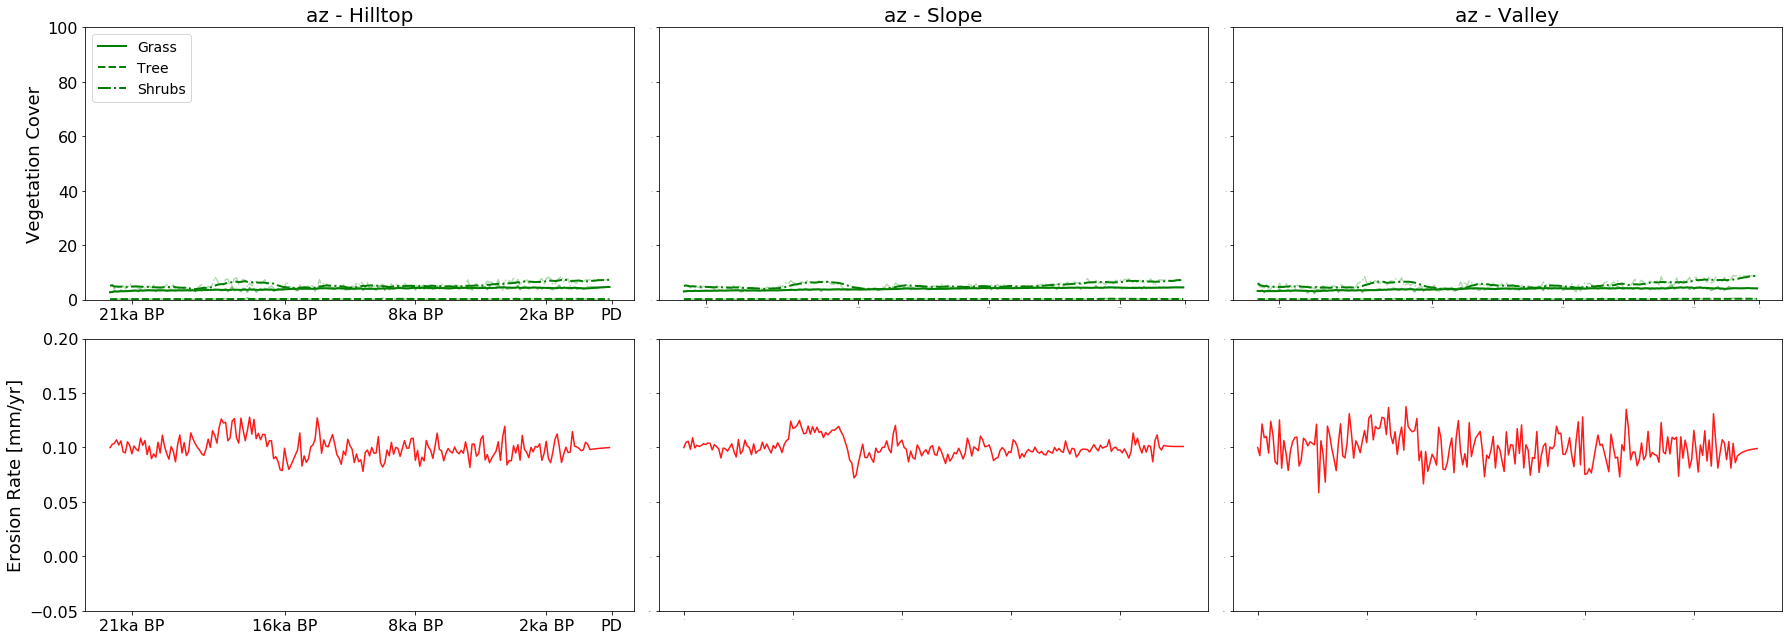

In [17]:
x1 = [1000, 8000, 14000, 20000, 23000]
labels = ['21ka BP','16ka BP','8ka BP','2ka BP', 'PD']


fig, ax = plt.subplots(2, 3, 
                  figsize = [25,9], 
                  sharex = False) 

#-------------left upper Panel - Hilltop
ax[0,0].set_title(area + ' - Hilltop', fontsize = 20)
#raw vegi
ax[0,0].plot(time_vector, top_grass_cover * 100, 'g', alpha = 0.5, linewidth = 1.5)
ax[0,0].plot(time_vector, top_tree_cover * 100, 'g--', alpha = 0.4, linewidth = 1.5)
ax[0,0].plot(time_vector, top_shrub_cover * 100, 'g-.', alpha = 0.3, linewidth = 1.5)
ax[0,0].set_xticks(x1)
ax[0,0].set_xticklabels(labels)

#smoothed vegi
df_1 = pd.DataFrame(top_grass_cover * 100)
smooth_df1 = df_1.rolling(10, min_periods=1).mean()
ax[0,0].plot(time_vector, smooth_df1, 'g', linewidth = 2, label = 'Grass')

df_2 = pd.DataFrame(top_tree_cover * 100)
smooth_df2 = df_2.rolling(10, min_periods=1).mean()
ax[0,0].plot(time_vector, smooth_df2,'g--', linewidth = 2, label = 'Tree')

df_3 = pd.DataFrame(top_shrub_cover * 100)
smooth_df3 = df_3.rolling(10, min_periods=1).mean()
ax[0,0].plot(time_vector, smooth_df3, 'g-.', linewidth = 2, label = 'Shrubs')

#legend
ax[0,0].legend(fontsize = 14, loc = 'upper left')
#labels
ax[0,0].set_ylabel('Vegetation Cover', fontsize = 18)
ax[0,0].set_ylim(0,100)
ax[0,0].axes.tick_params(labelsize = 16)

#-------------middle upper Panel - Slope
ax[0,1].set_title(area + ' - Slope', fontsize = 20)
ax[0,1].plot(time_vector, slope_grass_cover * 100, 'g', alpha = 0.5, linewidth = 1.5)
ax[0,1].plot(time_vector, slope_tree_cover * 100, 'g--', alpha = 0.4, linewidth = 1.5)
ax[0,1].plot(time_vector, slope_shrub_cover * 100, 'g-.', alpha = 0.3, linewidth = 1.5)
ax[0,1].set_xticks(x1)
ax[0,1].set_xticklabels(labels)

#smoothed vegi
df_1 = pd.DataFrame(slope_grass_cover * 100)
smooth_df1 = df_1.rolling(10, min_periods=1).mean()
ax[0,1].plot(time_vector, smooth_df1, 'g', linewidth = 2)
df_2 = pd.DataFrame(slope_tree_cover * 100)
smooth_df2 = df_2.rolling(10, min_periods=1).mean()
ax[0,1].plot(time_vector, smooth_df2, 'g--', linewidth = 2)
df_3 = pd.DataFrame(slope_shrub_cover * 100)
smooth_df3 = df_3.rolling(10, min_periods=1).mean()
ax[0,1].plot(time_vector, smooth_df3, 'g-.', linewidth = 2)
#labels
ax[0,0].set_ylabel('Vegetation Cover', fontsize = 18)
ax[0,1].set_ylim(0,100)
ax[0,1].axes.tick_params(labelsize = 16)
ax[0,1].axes.tick_params(labelsize = 0)


#-------------right upper Panel - Valley
ax[0,2].set_title(area + ' - Valley', fontsize = 20)
ax[0,2].plot(time_vector, valley_grass_cover * 100, 'g', alpha = 0.5, linewidth = 1.5)
ax[0,2].plot(time_vector, valley_tree_cover * 100, 'g--', alpha = 0.4, linewidth = 1.5)
ax[0,2].plot(time_vector, valley_shrub_cover * 100, 'g-.', alpha = 0.3, linewidth = 1.5)
ax[0,2].set_ylim(0,100)
ax[0,2].axes.tick_params(labelsize = 0)
ax[0,2].set_xticks(x1)
ax[0,2].set_xticklabels(labels)

#smoothed vegi
df_1 = pd.DataFrame(valley_grass_cover * 100)
smooth_df1 = df_1.rolling(10, min_periods=1).mean()
ax[0,2].plot(time_vector, smooth_df1, 'g', linewidth = 2)
df_2 = pd.DataFrame(valley_tree_cover * 100)
smooth_df2 = df_2.rolling(10, min_periods=1).mean()
ax[0,2].plot(time_vector, smooth_df2,  'g--', linewidth = 2)
df_3 = pd.DataFrame(valley_shrub_cover * 100)
smooth_df3 = df_3.rolling(10, min_periods=1).mean()
ax[0,2].plot(time_vector, smooth_df3,  'g-.', linewidth = 2)


#lower left Panel 
ax[1,0].plot(time_vector, top_erosion_rates * 1000, 'r', alpha = 0.9)
ax[1,0].set_ylabel('Erosion Rate [mm/yr]', fontsize = 18)
ax[1,0].axes.tick_params(labelsize = 16)
ax[1,0].set_ylim(-0.05,0.2)
ax[1,0].set_xticks(x1)
ax[1,0].set_xticklabels(labels)



#lower middle Panel
ax[1,1].plot(time_vector, slope_erosion_rates * 1000, 'r', alpha = 0.9)
ax[1,1].axes.tick_params(labelsize = 16)
ax[1,1].axes.tick_params(labelsize = 0)
ax[1,1].set_ylim(-0.05,0.2)


#lower right Panel
ax[1,2].plot(time_vector, valley_erosion_rates * 1000, 'r', alpha = 0.9)
ax[1,2].axes.tick_params(labelsize = 16)
ax[1,2].axes.tick_params(labelsize = 0)
ax[1,2].set_ylim(-0.05,0.2)


#general formatting
plt.tight_layout()

#plt.savefig('Plots/'+ area +'_slopeposition_vegi_pft_erosion_inv.png', dpi = 420)